In [1]:
import time
import numpy as np

import _init_paths
from libs.scheduler import PfScheduler
from libs.models.naive_solver import NaiveURLLCSolver
from libs.models.greedy_solver import GreedyURLLCSolver
from libs.models.nb_solver import CccpURLLCSolver
from utils.generator import generate
from utils.generator import urllc_generate
from utils.metrics import get_embb_utility

import matplotlib.pyplot as plt
import math

import matlab
import matlab.engine

D:\Develop\Code\URLLC\Joint-eMBB-URLLC
D:\Develop\Code\URLLC\Joint-eMBB-URLLC\libs\models


In [2]:
utility_result = []
embb_user_result = []
urllc_num_slot = []
utility_result_mid = []
engine = matlab.engine.start_matlab()

In [3]:
for i in range(6):
    urllc_per_slot = i

    rb_size = 15
    rb_num = 254
    embb_num = 3
    embb_slot_len = 7

    urllc_slot_len = 1
    max_sim_time_slot_len = embb_slot_len
    id_total = 0
    embb_rb_req = [100, 50, 120]
    embb_rb_size = [6000, 12000, 5000]
    urllc_rb_req = []
    urllc_rb_size = []
    urllc_slot_start = []
    embb_utility = 0

    urllc_num = (embb_slot_len - 1) * urllc_per_slot
    for i in range(embb_slot_len-1):
        for k in range(urllc_per_slot):
            urllc_rb_req.append(15)
            urllc_rb_size.append(30)
            urllc_slot_start.append(i+1)
    print(urllc_slot_start)
    print(urllc_rb_req)
    print(urllc_rb_size)
    urllc_num_slot.append(urllc_per_slot)

    #urllc scheduler setting
    #URLLCSolver = NaiveURLLCSolver
    #URLLCSolver = GreedyURLLCSolver
    URLLCSolver = CccpURLLCSolver
    global_time = 0
    global_timeout_urllc_users = []
    
    # generate eMBB
    embb_users, urllc_users, RB_map, id_total = generate(rb_size,
        rb_num,
        embb_num, 
        embb_slot_len, 
        urllc_num,
        urllc_slot_len,
        embb_rb_req,
        embb_rb_size,
        urllc_rb_req,
        urllc_rb_size,
        urllc_slot_start,
        latency=1,
        error_rate=1e-5,
        mcs_error=1e-5,
    )
    delay_users = []
    timer = []
    
    for i in range(30):
        pf_scheduler = PfScheduler(RB_map, embb_users)
        pf_scheduler.allocate_resource()



        # urllc_time_slot get urllc_active_come_list, setting urllc come from global_time=1 and later
        urllc_users.sort(key=lambda x:x.slot_start)
        urllc_come_time = np.array([u.slot_start for u in urllc_users])
        #print(urllc_come_time)
        #print(global_time)
        #print(max_sim_time_slot_len)
        while(global_time < max_sim_time_slot_len):
            global_time += 1
            #print(global_time)
            indexes = np.where(urllc_come_time==global_time)[0]
            if len(indexes) == 0:
                #print(indexes)
                continue
            urllc_users_list = delay_users + urllc_users.copy()[indexes[0]:indexes[-1]+1]


            urllc_scheduler = URLLCSolver(RB_map, embb_users, urllc_users_list, engine)

            start = time.time()
            ass_users, delay_users, timeout_users = urllc_scheduler.allocate_resource()
            timer.append(time.time() - start)

            global_timeout_urllc_users.append(timeout_users)

            #print(RB_map.__dict__.items())
            # urllc leave
            urllc_scheduler.leave(ass_users)

    # get_embb_utility miss_list and time cost for all the urllc scheduler
        embb_utility = get_embb_utility(embb_users)
        total_time_cost = sum(timer)

        # visualize (TODO)
        for user in embb_users:
            print(user .__dict__.items())
        
        print("\n")
        print(embb_utility)
        #print(RB_map.__dict__.items())

        # next embb_time_slot (not show here)

        #update URLLC
        for i in range(len(urllc_slot_start)):
            urllc_slot_start[i] += embb_slot_len


        urllc_users, id_total = urllc_generate(
            urllc_num,
            urllc_slot_len,
            urllc_rb_req,
            urllc_rb_size,
            urllc_slot_start,
            id_total,
            latency=1,
            error_rate=1e-5,
            mcs_error=1e-5,
        )

        max_sim_time_slot_len+=embb_slot_len
        avg_utiliy_mid = 0
        for user in embb_users:
            weighti = user.DRC
            if user.sche_times:
                avg_utiliy_mid += weighti * math.log(user.rate_avg)
        utility_result_mid.append(avg_utiliy_mid)
    avg_utiliy = 0
    for user in embb_users:
        weighti = user.DRC
        if user.sche_times:
            avg_utiliy += weighti * math.log(user.rate_avg)
    utility_result.append(avg_utiliy)
    embb_user_result.append(embb_users)

[]
[]
[]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 100), ('rb_start', 0), ('sche_times', 1), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 85.71428571428571), ('rate_cur', 85.71428571428571), ('replace_num', 0)])
dict_items([('user_info', {'id': 2}), ('rb_size', 12000), ('rb_num_req', 50), ('rb_num_ass', 50), ('rb_start', 100), ('sche_times', 1), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 85.71428571428571), ('rate_cur', 85.71428571428571), ('replace_num', 0)])
dict_items([('user_info', {'id': 3}), ('rb_size', 5000), ('rb_num_req', 120), ('rb_num_ass', 104), ('rb_start', 150), ('sche_times', 1), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 74.28571428571429), ('rate_cur', 74.28571428571429), ('replace_num', 0)])


1132.2820864150135
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb

[3]
[254]
[1, 100, 101, 150, 151, 254]
[85.71428571425461, 85.71428571425461, 72.75510204081121]
[700, 350, 728]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[1, 100, 101, 150, 151, 254]
[85.71428571423137, 85.71428571423138, 71.25602713611308]
[700, 350, 728]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[1, 100, 101, 150, 151, 254]
[85.71428571420937, 85.71428571420938, 69.7878397637924]
[700, 350, 728]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[1, 100, 101, 150, 151, 254]
[85.71428571418475, 85.71428571418478, 68.34990350493702]
[700, 350, 728]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[1, 100, 101, 150, 151, 254]
[85.71428571416031, 85.71428571416034, 66.94159505361266]
[700, 350, 728]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 100), ('

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999993892, 85.71428571421302, 81.20395798621405]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999991837, 85.71428571418856, 79.75388730787513]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999989774, 85.71428571416399, 78.32971074879251]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('rb_start', 170), ('sche_times', 5), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.48571428558196), ('rate_cur', 71.999999999877), ('replace_num', 0)])
dict_items([('user_info', {'id': 2}), ('rb_size', 12000), ('rb_num_req', 50), ('rb_num_ass', 50), ('rb_start', 120), ('sche_times', 5), ('active', 1), ('slot_l

[3]
[254]
[171, 254, 1, 50, 51, 170]
[71.99999999989774, 85.71428571416398, 78.32971074879251]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('rb_start', 170), ('sche_times', 9), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 78.09523809510483), ('rate_cur', 71.999999999877), ('replace_num', 0)])
dict_items([('user_info', {'id': 2}), ('rb_size', 12000), ('rb_num_req', 50), ('rb_num_ass', 50), ('rb_start', 0), ('sche_times', 9), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 76.57142857129791), ('rate_cur', 85.71428571413931), ('replace_num', 0)])
dict_items([('user_info', {'id': 3}), ('rb_size', 5000), ('rb_num_req', 120), ('rb_num_ass', 120), ('rb_start', 50), ('sche_times', 9), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('ra

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999997975, 85.7142857142616, 84.18367346937336]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999995939, 85.71428571423738, 82.68039358597755]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999993892, 85.71428571421302, 81.20395798621405]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999991837, 85.71428571418856, 79.75388730787513]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999989774, 85.71428571416399, 78.32971074879251]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('r

[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.7142857142173, 58.285714285667794, 82.68039358599623]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571420253, 58.28571428565776, 81.2039579862377]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571418767, 58.285714285647664, 79.75388730790289]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571417326, 58.28571428563788, 78.32971074882396]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 100), ('rb_start', 120), ('sche_times', 18), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.3333333332014), ('rate_cur', 85.71428571413988

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999991837, 85.71428571418856, 79.75388730787513]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999989774, 85.71428571416399, 78.32971074879251]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[1]
[15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('rb_start', 170), ('sche_times', 22), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 76.98701298688164), ('rate_cur', 71.999999999877), ('replace_num', 0)])
dict_items([('user_info', {'id': 2}), ('rb_size', 12000), ('rb_num_req', 50), ('rb_num_ass', 50), ('rb_start', 120), ('sche_times', 22), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 76.9870129868816), ('rate_cur', 85.71428571413932), ('replace_num', 0)])
dict_items([('user_info', {'id': 3}

dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('rb_start', 170), ('sche_times', 26), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 76.74725274712179), ('rate_cur', 71.999999999877), ('replace_num', 0)])
dict_items([('user_info', {'id': 2}), ('rb_size', 12000), ('rb_num_req', 50), ('rb_num_ass', 50), ('rb_start', 120), ('sche_times', 26), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.27472527459341), ('rate_cur', 85.71428571413932), ('replace_num', 0)])
dict_items([('user_info', {'id': 3}), ('rb_size', 5000), ('rb_num_req', 120), ('rb_num_ass', 120), ('rb_start', 0), ('sche_times', 26), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 76.49370968448103), ('rate_cur', 76.93096591397945), ('replace_num', 0)])


1120.3366369986177
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571428571, 58.28571428

[3]
[254]
[1, 100, 101, 150, 151, 254]
[85.71428571426688, 85.71428571426688, 71.22448979591742]
[700, 350, 728]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[1, 100, 101, 150, 151, 254]
[85.71428571421669, 85.7142857142167, 68.2894146669434]
[700, 350, 728]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[1, 100, 101, 150, 151, 254]
[85.71428571415599, 85.71428571415602, 65.47529043613774]
[700, 350, 728]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[1, 100, 101, 150, 151, 254]
[85.71428571408671, 85.71428571408676, 62.777132863192364]
[700, 350, 728]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[1, 100, 101, 150, 151, 254]
[85.71428571400932, 85.71428571400939, 60.190163102316774]
[700, 350, 728]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999992626, 85.71428571419794, 79.70116618070959]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999987975, 85.71428571414259, 76.8546959599403]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999982906, 85.71428571408225, 74.10988538991116]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999977445, 85.71428571401725, 71.46310376881031]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('rb_start', 170), ('sche_times', 5), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.48571428543761), ('rate_cur', 71.

[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571419929, 58.28571428565559, 76.85469596004215]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571416992, 58.285714285635635, 74.1098853900492]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571414026, 58.28571428561549, 71.46310376898447]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 100), ('rb_start', 120), ('sche_times', 9), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 78.09523809498208), ('rate_cur', 85.7142857141103), ('replace_num', 0)])
dict_items([('user_info', {'id': 2}), ('rb_size', 12000), ('rb_num_req', 50), ('rb_num_ass', 34), ('rb_start', 220), ('sche_times', 9), ('active'

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999982906, 85.71428571408225, 74.10988538991116]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999977445, 85.71428571401725, 71.46310376881031]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('rb_start', 170), ('sche_times', 13), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.27472527446878), ('rate_cur', 71.99999999971497), ('replace_num', 0)])
dict_items([('user_info', {'id': 2}), ('rb_size', 12000), ('rb_num_req', 50), ('rb_num_ass', 50), ('rb_start', 120), ('sche_times', 13), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.27472527445269), ('rate_cur', 85.71428571394647), ('replace_num', 0)])
dict_items([('user_info'

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999977445, 85.71428571401725, 71.46310376881031]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('rb_start', 170), ('sche_times', 17), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 76.840336134197), ('rate_cur', 71.99999999971497), ('replace_num', 0)])
dict_items([('user_info', {'id': 2}), ('rb_size', 12000), ('rb_num_req', 50), ('rb_num_ass', 50), ('rb_start', 120), ('sche_times', 17), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.6470588232541), ('rate_cur', 85.71428571394647), ('replace_num', 0)])
dict_items([('user_info', {'id': 3}), ('rb_size', 5000), ('rb_num_req', 120), ('rb_num_ass', 120), ('rb_start', 0), ('sche_times', 17), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0

dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 100), ('rb_start', 120), ('sche_times', 21), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.22448979566666), ('rate_cur', 85.7142857141103), ('replace_num', 0)])
dict_items([('user_info', {'id': 2}), ('rb_size', 12000), ('rb_num_req', 50), ('rb_num_ass', 34), ('rb_start', 220), ('sche_times', 21), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 76.57142857116207), ('rate_cur', 58.28571428559514), ('replace_num', 0)])
dict_items([('user_info', {'id': 3}), ('rb_size', 5000), ('rb_num_req', 120), ('rb_num_ass', 120), ('rb_start', 0), ('sche_times', 21), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 68.37746669021884), ('rate_cur', 68.91085006295765), ('replace_num', 0)])


1092.787729083588
[3]
[254]
[171, 254, 121, 170, 1, 120]
[72.0, 85.71428571428571, 85.7

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999996669, 85.71428571424606, 82.6530612244672]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999992626, 85.71428571419794, 79.70116618070959]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999987975, 85.71428571414259, 76.8546959599403]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999982906, 85.71428571408225, 74.10988538991116]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999977445, 85.71428571401725, 71.46310376881031]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb

[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571422837, 58.28571428567533, 79.70116618077545]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571419929, 58.28571428565559, 76.85469596004215]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571416992, 58.285714285635635, 74.1098853900492]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571414026, 58.28571428561549, 71.46310376898447]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[2]
[15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 100), ('rb_start', 120), ('sche_times', 30), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.02857142832066), ('rate_cur', 

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999995943, 85.71428571423742, 81.12244897960933]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999991886, 85.71428571418913, 76.7766034985754]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999987851, 85.71428571414111, 72.66357116831016]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999983906, 85.71428571409417, 68.77087985573648]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999980074, 85.71428571404857, 65.08672557776376]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999991886, 85.71428571418913, 76.7766034985754]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999987851, 85.71428571414111, 72.66357116831016]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999983906, 85.71428571409417, 68.77087985573648]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999980074, 85.71428571404857, 65.08672557776376]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('rb_start', 170), ('sche_times', 8), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.14285714260814), 

[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.7142857141969, 58.28571428565398, 76.77660349857172]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571415247, 58.285714285623804, 72.66357116830501]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571410803, 58.28571428559362, 68.77087985573043]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571406354, 58.28571428556341, 65.08672557775733]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 100), ('rb_start', 120), ('sche_times', 12), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.7142857140358)

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999991886, 85.71428571418913, 76.7766034985754]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999987851, 85.71428571414111, 72.66357116831016]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999983906, 85.71428571409417, 68.77087985573648]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999980074, 85.71428571404857, 65.08672557776376]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('rb_start', 170), ('sche_times', 16), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.1428571426086), 

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999991886, 85.71428571418913, 76.7766034985754]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999987851, 85.71428571414111, 72.66357116831016]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999983906, 85.71428571409417, 68.77087985573648]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999980074, 85.71428571404857, 65.08672557776376]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('rb_start', 170), ('sche_times', 20), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 76.79999999975229),

[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.7142857141969, 58.28571428565398, 76.77660349857172]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571415247, 58.285714285623804, 72.66357116830501]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571410803, 58.28571428559362, 68.77087985573043]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571406354, 58.28571428556341, 65.08672557775733]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 100), ('rb_start', 120), ('sche_times', 24), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 77.14285714260869

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999991886, 85.71428571418913, 76.7766034985754]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999987851, 85.71428571414111, 72.66357116831016]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999983906, 85.71428571409417, 68.77087985573648]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999980074, 85.71428571404857, 65.08672557776376]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[3]
[15, 15, 15]
dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('rb_start', 170), ('sche_times', 28), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 76.89795918342554),

[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571424171, 58.28571428568443, 79.59183673471126]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.7142857141974, 58.28571428565432, 73.90670553937824]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571408194, 58.28571428557587, 68.62765514368432]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571401731, 58.285714285531974, 63.725679776298605]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571400716, 58.28571428552508, 59.173845506561605]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
dict_items([('user_info', {'id': 1}), 

[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571424171, 58.28571428568443, 79.59183673471126]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.7142857141974, 58.28571428565432, 73.90670553937824]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571408194, 58.28571428557587, 68.62765514368432]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571401731, 58.285714285531974, 63.725679776298605]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571400716, 58.28571428552508, 59.173845506561605]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
dict_items([('user_info', {'id': 1}), 

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999989544, 85.71428571416129, 79.59183673474438]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999979713, 85.71428571404432, 73.90670553944678]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999949475, 85.71428571368442, 68.62765514382802]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999943991, 85.71428571361916, 63.72567977643262]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999941465, 85.7142857135891, 59.17384550669148]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
dict_items([('user_info', {'id': 1}), ('r

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999989544, 85.71428571416129, 79.59183673474438]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999979713, 85.71428571404432, 73.90670553944678]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999949475, 85.71428571368442, 68.62765514382802]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999943991, 85.71428571361916, 63.72567977643262]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999941465, 85.7142857135891, 59.17384550669148]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
dict_items([('user_info', {'id': 1}), ('r

[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571424171, 58.28571428568443, 79.59183673471126]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.7142857141974, 58.28571428565432, 73.90670553937824]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571408194, 58.28571428557587, 68.62765514368432]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571401731, 58.285714285531974, 63.725679776298605]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571400716, 58.28571428552508, 59.173845506561605]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
dict_items([('user_info', {'id': 1}), 

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999989544, 85.71428571416129, 79.59183673474438]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999979713, 85.71428571404432, 73.90670553944678]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999949475, 85.71428571368442, 68.62765514382802]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999943991, 85.71428571361916, 63.72567977643262]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999941465, 85.7142857135891, 59.17384550669148]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
dict_items([('user_info', {'id': 1}), ('r

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999989544, 85.71428571416129, 79.59183673474438]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999979713, 85.71428571404432, 73.90670553944678]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999949475, 85.71428571368442, 68.62765514382802]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999943991, 85.71428571361916, 63.72567977643262]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999941465, 85.7142857135891, 59.17384550669148]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
dict_items([('user_info', {'id': 1}), ('r

[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571424171, 58.28571428568443, 79.59183673471126]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.7142857141974, 58.28571428565432, 73.90670553937824]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571408194, 58.28571428557587, 68.62765514368432]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571401731, 58.285714285531974, 63.725679776298605]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571400716, 58.28571428552508, 59.173845506561605]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[4]
[15, 15, 15, 15]
dict_items([('user_info', {'id': 1}), 

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999952526, 85.71428571372066, 78.06122448977592]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999932288, 85.7142857134798, 71.09147230337743]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999911219, 85.714285713229, 64.74401941936392]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999891489, 85.71428571299417, 58.963303399940465]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999881304, 85.71428571287295, 53.69872273924656]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
dict_items([('user_inf

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999952526, 85.71428571372066, 78.06122448977592]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999932288, 85.7142857134798, 71.09147230337743]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999911219, 85.714285713229, 64.74401941936392]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999891489, 85.71428571299417, 58.963303399940465]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999881304, 85.71428571287295, 53.69872273924656]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
dict_items([('user_inf

[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571357727, 58.28571428523288, 78.06122449050643]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571355668, 58.28571428521888, 71.0914723038517]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571330296, 58.285714285046446, 64.74401941979961]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571306818, 58.285714284886915, 58.96330340034012]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571294703, 58.28571428480462, 53.69872273961035]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
dict_items([('user_

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999952526, 85.71428571372066, 78.06122448977592]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999932288, 85.7142857134798, 71.09147230337743]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999911219, 85.714285713229, 64.74401941936392]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999891489, 85.71428571299417, 58.963303399940465]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999881304, 85.71428571287295, 53.69872273924656]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
dict_items([('user_inf

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999952526, 85.71428571372066, 78.06122448977592]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999932288, 85.7142857134798, 71.09147230337743]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999911219, 85.714285713229, 64.74401941936392]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999891489, 85.71428571299417, 58.963303399940465]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999881304, 85.71428571287295, 53.69872273924656]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
dict_items([('user_inf

[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571357727, 58.28571428523288, 78.06122449050643]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571355668, 58.28571428521888, 71.0914723038517]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571330296, 58.285714285046446, 64.74401941979961]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571306818, 58.285714284886915, 58.96330340034012]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[121, 220, 221, 254, 1, 120]
[85.71428571294703, 58.28571428480462, 53.69872273961035]
[700, 238, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
dict_items([('user_

[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999952526, 85.71428571372066, 78.06122448977592]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999932288, 85.7142857134798, 71.09147230337743]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999911219, 85.714285713229, 64.74401941936392]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999891489, 85.71428571299417, 58.963303399940465]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
[3]
[254]
[171, 254, 121, 170, 1, 120]
[71.99999999881304, 85.71428571287295, 53.69872273924656]
[588, 350, 840]
[85.71428571428571, 85.71428571428571, 85.71428571428571]
[5]
[15, 15, 15, 15, 15]
dict_items([('user_inf

In [4]:
utility_result

[1128.5954245207226,
 1116.0317835763296,
 1106.5526739688898,
 1096.8961944482458,
 1087.0555978878278,
 1077.023745348184]

In [10]:
utility_result_mid

[1132.2820864150135,
 1123.6896222729229,
 1126.2850640370343,
 1127.988175160249,
 1128.5117723124354,
 1129.2385006290476,
 1127.275207307102,
 1127.7007038375264,
 1128.2911234086905,
 1128.5117723124354,
 1128.9130362486085,
 1127.803736503586,
 1128.0159824309046,
 1128.3721495988468,
 1128.5117723124354,
 1128.7888960265673,
 1129.0288321731332,
 1128.2911234086905,
 1128.4096692347234,
 1128.6355028077055,
 1128.72341497386,
 1128.9130362486085,
 1128.3407373442387,
 1128.4312996660724,
 1128.611595501945,
 1128.6829633785503,
 1128.8396093608271,
 1128.3721495988468,
 1128.4453689636418,
 1128.5954245207226,
 1121.5748492694806,
 1113.757132642243,
 1116.585428453807,
 1117.7605863358322,
 1118.3897751129416,
 1116.3284935989723,
 1117.0154445004823,
 1115.5789356382136,
 1116.2147617714843,
 1116.7035106813148,
 1117.0903881787835,
 1116.1526005823025,
 1116.5322633301294,
 1116.8497635645401,
 1116.1136050579225,
 1116.4240668321916,
 1116.6926625557119,
 1116.0868991433238,


In [45]:
avg_utiliy = 0
for user in embb_users:
    print(user .__dict__.items())
    weighti = user.DRC
    if user.sche_times:
        avg_utiliy += weighti * math.log(user.rate_avg)
print(embb_utility)
print(utility_result)
print(avg_utiliy)

dict_items([('user_info', {'id': 1}), ('rb_size', 6000), ('rb_num_req', 100), ('rb_num_ass', 84), ('rb_start', 170), ('sche_times', 30), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 76.6803504835999), ('rate_cur', 72.0), ('replace_num', 0)])
dict_items([('user_info', {'id': 2}), ('rb_size', 12000), ('rb_num_req', 50), ('rb_num_ass', 50), ('rb_start', 120), ('sche_times', 30), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 76.57142857142858), ('rate_cur', 85.71428571428571), ('replace_num', 0)])
dict_items([('user_info', {'id': 3}), ('rb_size', 5000), ('rb_num_req', 120), ('rb_num_ass', 120), ('rb_start', 0), ('sche_times', 30), ('active', 1), ('slot_len', 7), ('DRC', 85.71428571428571), ('rate_slot', 0.0), ('rate_avg', 54.80414444792495), ('rate_cur', 54.94714225608135), ('replace_num', 0)])
1091.4906255784617
[1096.8362631709008, 1086.9973131959]
1086.9973131959


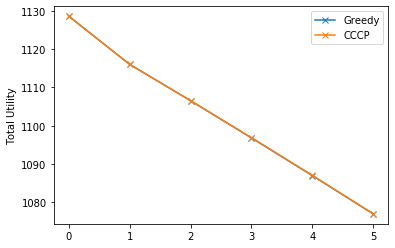

In [9]:
utility_dc = [1128.5954245207226,1116.0317835763296,1106.5526739688898,1096.8961944482458,1087.0555978878278,1077.023745348184,1028.7194246598528]
utility_greedy = [1128.5954245207226,1116.0317835766946,1106.5526739695815,1096.8362631709008,1086.9973131959,1076.9869891022395,1024.1715258762304]
utility_rr = [1128.5954245207226,1109.3752293397433,1104.9716961927409,1093.326993864293,1081.4125062337894,1069.2154354020272]
#plt.plot(urllc_num_slot,utility_rr, label='Round Robin',marker='x')
plt.plot(urllc_num_slot,utility_greedy, label='Greedy',marker='x')
plt.plot(urllc_num_slot,utility_dc, label='CCCP',marker='x')

plt.ylabel("Total Utility")
plt.legend()

## Case 2

In [11]:
utility_result = []
embb_user_result = []
urllc_num_slot = []
utility_result_mid = []

In [ ]:
for i in range(6):
    urllc_per_slot = i

    rb_size = 15
    rb_num = 274
    embb_num = 5
    embb_slot_len = 7

    urllc_slot_len = 1
    max_sim_time_slot_len = embb_slot_len
    id_total = 0
    embb_rb_req = [60, 80, 40,50,70]
    embb_rb_size = [7000, 5200, 10000, 8400, 6000]
    urllc_rb_req = []
    urllc_rb_size = []
    urllc_slot_start = []
    embb_utility = 0

    urllc_num = (embb_slot_len - 1) * urllc_per_slot
    for i in range(embb_slot_len-1):
        for k in range(urllc_per_slot):
            urllc_rb_req.append(15)
            urllc_rb_size.append(30)
            urllc_slot_start.append(i+1)
    print(urllc_slot_start)
    print(urllc_rb_req)
    print(urllc_rb_size)
    urllc_num_slot.append(urllc_per_slot)

    #urllc scheduler setting
    #URLLCSolver = NaiveURLLCSolver
    #URLLCSolver = GreedyURLLCSolver
    URLLCSolver = CccpURLLCSolver
    global_time = 0
    global_timeout_urllc_users = []
    
    # generate eMBB
    embb_users, urllc_users, RB_map, id_total = generate(rb_size,
        rb_num,
        embb_num, 
        embb_slot_len, 
        urllc_num,
        urllc_slot_len,
        embb_rb_req,
        embb_rb_size,
        urllc_rb_req,
        urllc_rb_size,
        urllc_slot_start,
        latency=1,
        error_rate=1e-5,
        mcs_error=1e-5,
    )
    delay_users = []
    timer = []
    
    for i in range(30):
        pf_scheduler = PfScheduler(RB_map, embb_users)
        pf_scheduler.allocate_resource()



        # urllc_time_slot get urllc_active_come_list, setting urllc come from global_time=1 and later
        urllc_users.sort(key=lambda x:x.slot_start)
        urllc_come_time = np.array([u.slot_start for u in urllc_users])
        #print(urllc_come_time)
        #print(global_time)
        #print(max_sim_time_slot_len)
        while(global_time < max_sim_time_slot_len):
            global_time += 1
            #print(global_time)
            indexes = np.where(urllc_come_time==global_time)[0]
            if len(indexes) == 0:
                #print(indexes)
                continue
            urllc_users_list = delay_users + urllc_users.copy()[indexes[0]:indexes[-1]+1]


            urllc_scheduler = URLLCSolver(RB_map, embb_users, urllc_users_list, engine)

            start = time.time()
            ass_users, delay_users, timeout_users = urllc_scheduler.allocate_resource()
            timer.append(time.time() - start)

            global_timeout_urllc_users.append(timeout_users)

            #print(RB_map.__dict__.items())
            # urllc leave
            urllc_scheduler.leave(ass_users)

    # get_embb_utility miss_list and time cost for all the urllc scheduler
        embb_utility = get_embb_utility(embb_users)
        total_time_cost = sum(timer)

        # visualize (TODO)
        for user in embb_users:
            print(user .__dict__.items())
        
        print("\n")
        print(embb_utility)
        #print(RB_map.__dict__.items())

        # next embb_time_slot (not show here)

        #update URLLC
        for i in range(len(urllc_slot_start)):
            urllc_slot_start[i] += embb_slot_len


        urllc_users, id_total = urllc_generate(
            urllc_num,
            urllc_slot_len,
            urllc_rb_req,
            urllc_rb_size,
            urllc_slot_start,
            id_total,
            latency=1,
            error_rate=1e-5,
            mcs_error=1e-5,
        )

        max_sim_time_slot_len+=embb_slot_len
        avg_utiliy_mid = 0
        for user in embb_users:
            weighti = user.DRC
            if user.sche_times:
                avg_utiliy_mid += weighti * math.log(user.rate_avg)
        utility_result_mid.append(avg_utiliy_mid)
    avg_utiliy = 0
    for user in embb_users:
        weighti = user.DRC
        if user.sche_times:
            avg_utiliy += weighti * math.log(user.rate_avg)
    utility_result.append(avg_utiliy)
    embb_user_result.append(embb_users)

[]
[]
[]
dict_items([('user_info', {'id': 1}), ('rb_size', 7000), ('rb_num_req', 60), ('rb_num_ass', 60), ('rb_start', 0), ('sche_times', 1), ('active', 1), ('slot_len', 7), ('DRC', 60.0), ('rate_slot', 0.0), ('rate_avg', 60.0), ('rate_cur', 60.0), ('replace_num', 0)])
dict_items([('user_info', {'id': 2}), ('rb_size', 5200), ('rb_num_req', 80), ('rb_num_ass', 80), ('rb_start', 180), ('sche_times', 1), ('active', 1), ('slot_len', 7), ('DRC', 59.42857142857143), ('rate_slot', 0.0), ('rate_avg', 59.42857142857143), ('rate_cur', 59.42857142857143), ('replace_num', 0)])
dict_items([('user_info', {'id': 3}), ('rb_size', 10000), ('rb_num_req', 40), ('rb_num_ass', 14), ('rb_start', 260), ('sche_times', 1), ('active', 1), ('slot_len', 7), ('DRC', 57.142857142857146), ('rate_slot', 0.0), ('rate_avg', 20.0), ('rate_cur', 20.0), ('replace_num', 0)])
dict_items([('user_info', {'id': 4}), ('rb_size', 8400), ('rb_num_req', 50), ('rb_num_ass', 50), ('rb_start', 60), ('sche_times', 1), ('active', 1), (

[5]
[274]
[1, 60, 181, 260, 261, 274, 61, 110, 111, 180]
[59.99999999997767, 57.8367346938922, 19.99999999999262, 59.999999999977675, 59.99999999997765]
[420, 560, 98, 350, 490]
[60.0, 59.42857142857143, 57.142857142857146, 60.0, 60.0]
[1]
[15]
[5]
[274]
[1, 60, 181, 260, 261, 274, 61, 110, 111, 180]
[59.99999999995579, 56.2875364431775, 19.9999999999854, 59.99999999995581, 59.99999999995577]
[420, 560, 98, 350, 490]
[60.0, 59.42857142857143, 57.142857142857146, 60.0, 60.0]
[1]
[15]
[5]
[274]
[1, 60, 181, 260, 261, 274, 61, 110, 111, 180]
[59.9999999999344, 54.779834574178295, 19.99999999997834, 59.99999999993444, 59.999999999934374]
[420, 560, 98, 350, 490]
[60.0, 59.42857142857143, 57.142857142857146, 60.0, 60.0]
[1]
[15]
[5]
[274]
[1, 60, 181, 260, 261, 274, 61, 110, 111, 180]
[59.999999999913456, 53.31251757667001, 19.999999999971426, 59.9999999999135, 59.99999999991342]
[420, 560, 98, 350, 490]
[60.0, 59.42857142857143, 57.142857142857146, 60.0, 60.0]
[1]
[15]
[5]
[274]
[1, 60, 18